<a href="https://colab.research.google.com/github/KirpaDmitriy/AIAlgsImplementation/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

P4155

## Данные

In [ ]:
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("Steel_industry_data.csv")
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load


Тагрет - `Usage_kWh`, будем предсказывать его исходя из исторических данных, не используя остальные признаки набора

In [ ]:
list(data.date.values) == sorted(data.date.values)

False

In [ ]:
for n, (el1, el2) in enumerate(zip(data.date.values, sorted(data.date.values))):
  if el1 != el2:
    print(el1, el2, n)
    break

01/01/2018 00:15 01/01/2018 00:00 0


In [ ]:
data.date.values

array(['01/01/2018 00:15', '01/01/2018 00:30', '01/01/2018 00:45', ...,
       '08/10/2018 10:30', '08/10/2018 10:45', '08/1'], dtype=object)

In [ ]:
mask = data.date == '01/01/2018 00:00'

row_indices = data.loc[mask].index
row_indices

Index([95], dtype='int64')

In [ ]:
data

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.00,73.21,100.0,900.0,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.00,66.77,100.0,1800.0,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.00,70.28,100.0,2700.0,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.00,68.09,100.0,3600.0,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.00,64.72,100.0,4500.0,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
26919,08/10/2018 10:00,97.45,50.76,0.0,0.04,88.69,100.0,36000.0,Weekday,Monday,Medium_Load
26920,08/10/2018 10:15,72.54,47.41,0.0,0.03,83.71,100.0,36900.0,Weekday,Monday,Maximum_Load
26921,08/10/2018 10:30,105.88,60.73,0.0,0.05,86.74,100.0,37800.0,Weekday,Monday,Maximum_Load
26922,08/10/2018 10:45,103.25,49.64,0.0,0.05,90.13,100.0,38700.0,Weekday,Monday,Maximum_Load


In [ ]:
data = data[data.date != "08/1"]
data

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.00,73.21,100.0,900.0,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.00,66.77,100.0,1800.0,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.00,70.28,100.0,2700.0,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.00,68.09,100.0,3600.0,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.00,64.72,100.0,4500.0,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
26918,08/10/2018 09:45,104.04,56.92,0.0,0.05,87.73,100.0,35100.0,Weekday,Monday,Medium_Load
26919,08/10/2018 10:00,97.45,50.76,0.0,0.04,88.69,100.0,36000.0,Weekday,Monday,Medium_Load
26920,08/10/2018 10:15,72.54,47.41,0.0,0.03,83.71,100.0,36900.0,Weekday,Monday,Maximum_Load
26921,08/10/2018 10:30,105.88,60.73,0.0,0.05,86.74,100.0,37800.0,Weekday,Monday,Maximum_Load


In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
data.head()

<ipython-input-15-66014fa2dedc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load


In [ ]:
data = data[['date', 'Usage_kWh']].sort_values(by='date')
data.head()

,date,Usage_kWh
95,2018-01-01 00:00:00,3.42
0,2018-01-01 00:15:00,3.17
1,2018-01-01 00:30:00,4.00
2,2018-01-01 00:45:00,3.24
3,2018-01-01 01:00:00,3.31


In [ ]:
all(data['date'].values == sorted(data['date'].values))

True

In [ ]:
mean = data['Usage_kWh'].mean()
std = data['Usage_kWh'].std()
data['Usage_kWh_norm'] = (data['Usage_kWh'] - mean) / std
data.head()

,date,Usage_kWh,Usage_kWh_norm
95,2018-01-01 00:00:00,3.42,-0.719358
0,2018-01-01 00:15:00,3.17,-0.726755
1,2018-01-01 00:30:00,4.00,-0.702198
2,2018-01-01 00:45:00,3.24,-0.724684
3,2018-01-01 01:00:00,3.31,-0.722612


In [ ]:
fig = px.line(data, x='date', y='Usage_kWh')

fig.update_layout(
    title='Временной ряд потребление электроэнергии',
    xaxis_title='Дата',
    yaxis_title='Usage_kWh'
)

fig.show()

Видны непонятные провалы в феврале, августе и сентябре. Пример: с 21 по 26 сентября потребление на 1-2 порядка меньше соседних дат.

## RNN из pytorch

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len, forecast_len):
        self.series = series
        self.seq_len = seq_len
        self.forecast_len = forecast_len

    def __len__(self):
        return len(self.series) - self.seq_len - self.forecast_len + 1

    def __getitem__(self, idx):
        seq = self.series[idx:idx + self.seq_len]
        target = self.series[idx + self.seq_len:idx + self.seq_len + self.forecast_len]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, nonlinearity='tanh'):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity=nonlinearity, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last hidden state
        return out

In [ ]:
seq_len = 20  # Глубина просматриваемой последовательности
forecast_len = 5  # Глубина предсказания
batch_size = 32

dataset = TimeSeriesDataset(data['Usage_kWh_norm'].values, seq_len, forecast_len)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = RNNModel(input_size=1, hidden_size=128, output_size=forecast_len)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
train_losses = []
test_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.view(-1, seq_len, 1)
        targets = targets.view(-1, forecast_len)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Эпоха {epoch+1}, Значение функции потерь: {total_loss / len(train_loader)}')
    train_losses.append(total_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.view(-1, seq_len, 1)
            targets = targets.view(-1, forecast_len)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()
        print(f'Значение функции потерь на тестовой выборке {epoch+1}: {total_test_loss / len(test_loader)}')
        test_losses.append(total_test_loss)

Эпоха 1, Значение функции потерь: 0.3955780532568285
Значение функции потерь на тестовой выборке 1: 0.3971009571530503
Эпоха 2, Значение функции потерь: 0.32982249306642436
Значение функции потерь на тестовой выборке 2: 0.3227328130779745
Эпоха 3, Значение функции потерь: 0.28804145008750837
Значение функции потерь на тестовой выборке 3: 0.32149259331019503
Эпоха 4, Значение функции потерь: 0.2677286592435483
Значение функции потерь на тестовой выборке 4: 0.2748570517045722
Эпоха 5, Значение функции потерь: 0.2551439311440405
Значение функции потерь на тестовой выборке 5: 0.27062236791536143
Эпоха 6, Значение функции потерь: 0.24576534579197565
Значение функции потерь на тестовой выборке 6: 0.2826463848046244
Эпоха 7, Значение функции потерь: 0.24073249022540164
Значение функции потерь на тестовой выборке 7: 0.2591363874744607
Эпоха 8, Значение функции потерь: 0.23696286006316067
Значение функции потерь на тестовой выборке 8: 0.2509023862886647
Эпоха 9, Значение функции потерь: 0.23264

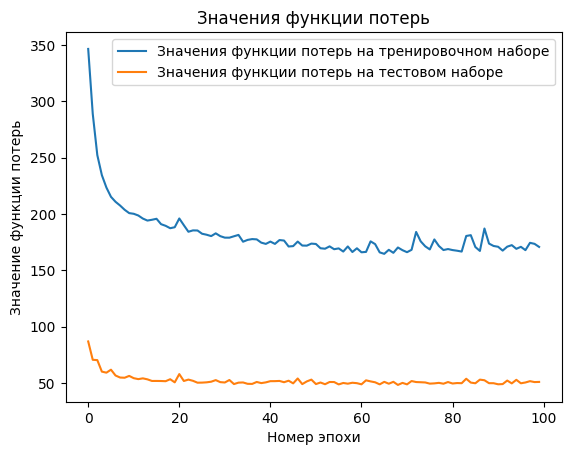

In [ ]:
x_values = range(len(train_losses))

plt.plot(x_values, train_losses, label='Значения функции потерь на тренировочном наборе')
plt.plot(x_values, test_losses, label='Значения функции потерь на тестовом наборе')

plt.title('Значения функции потерь')
plt.xlabel('Номер эпохи')
plt.ylabel('Значение функции потерь')

plt.legend()

plt.show()

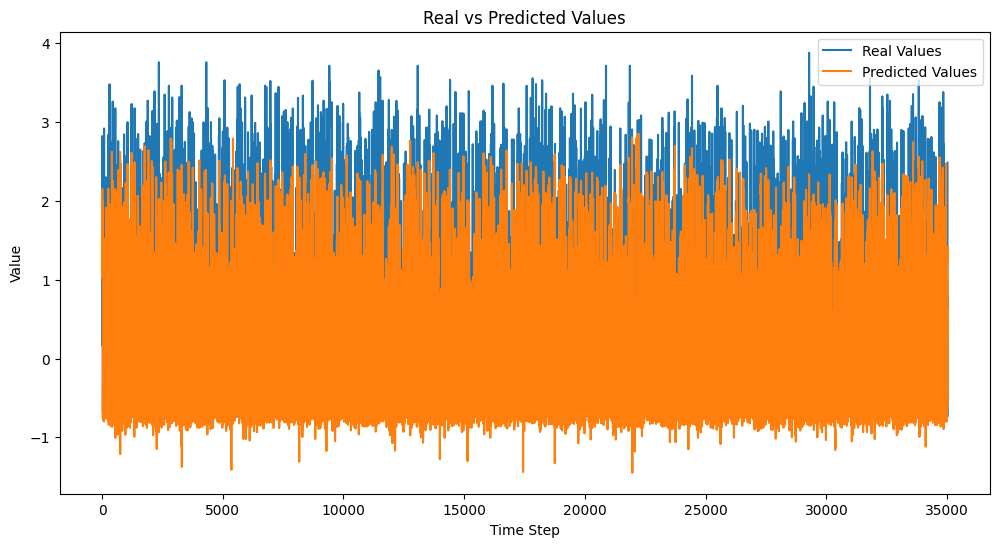

In [ ]:
model.eval()
predicted_values = []
real_values = []
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.view(-1, seq_len, 1)
        targets = targets.view(-1, forecast_len)
        outputs = model(inputs)
        predicted_values.extend(outputs.numpy().flatten())
        real_values.extend(targets.numpy().flatten())

plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Real Values')
plt.plot(predicted_values, label='Predicted Values')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Real vs Predicted Values')
plt.show()

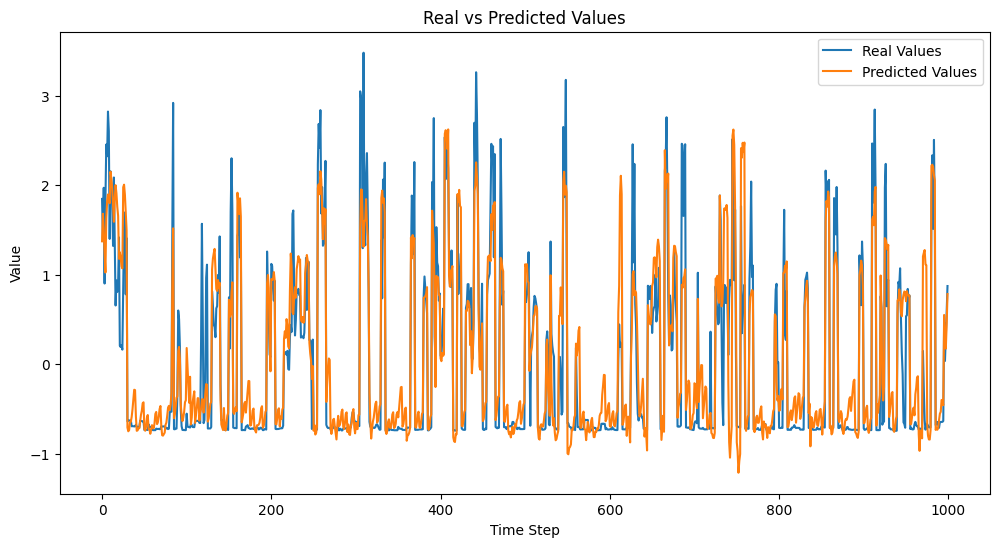

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(real_values[0:1000], label='Real Values')
plt.plot(predicted_values[0:1000], label='Predicted Values')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Real vs Predicted Values')
plt.show()

## Ручная реализация RNN

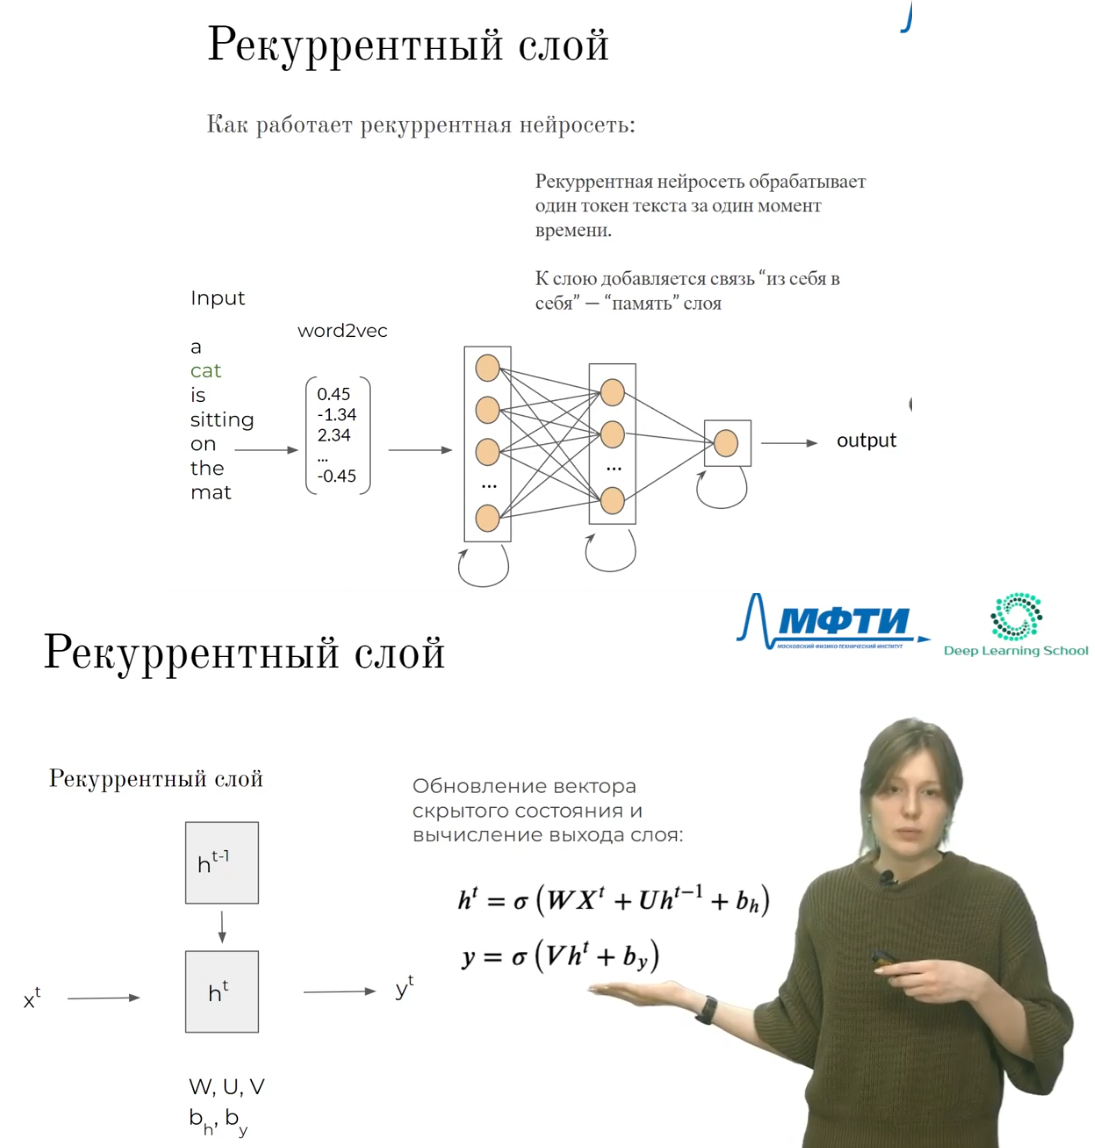

Про прямой проход: https://vk.com/video-155161349_456239185

Про обучение: https://vkvideo.ru/video-155161349_456239186

### Типы нейронок

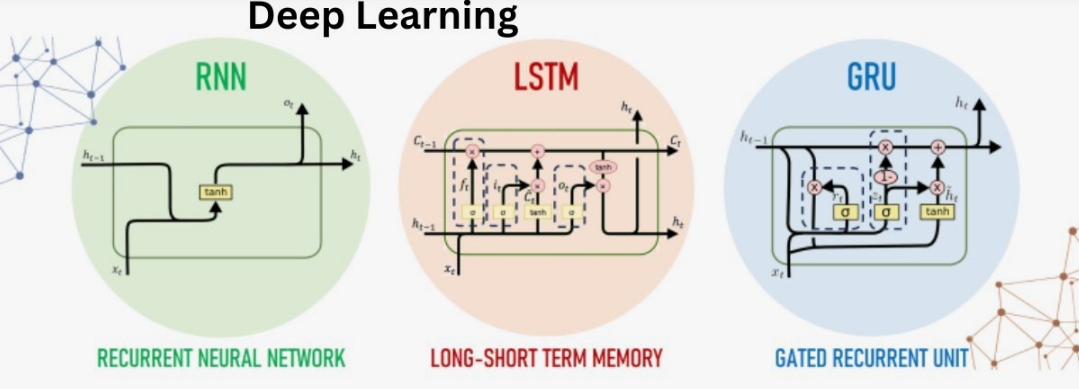

### Ванильная

In [ ]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        np.random.seed(1)
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.h_prev = np.zeros((self.Whh.shape[0], 1))
        self.losses = [[], []]

    def forward_pass(self, inputs):
        outputs, hidden_states = {}, {}
        h_prev = self.h_prev
        for t in range(len(inputs)):
            h_next = np.tanh(np.dot(self.Wxh, inputs[t]) + np.dot(self.Whh, h_prev) + self.bh)
            y_pred = np.dot(self.Why, h_next) + self.by
            y_prob = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=0)
            outputs[t] = y_prob
            hidden_states[t] = h_next
            h_prev = h_next
        self.h_prev = h_prev
        return outputs, hidden_states

    def backward_pass(self, inputs, outputs, hidden_states, targets):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros_like(hidden_states[0])

        for t in reversed(range(len(inputs))):
            dy = np.copy(outputs[t])
            dy[targets[t]] -= 1
            dWhy += np.dot(dy, hidden_states[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_rec_tanh = (1 - hidden_states[t] ** 2) * dh
            dbh += dh_rec_tanh
            dWhh += np.dot(dh_rec_tanh, hidden_states[t - 1].T if t != 0 else 0)
            dWxh += np.dot(dh_rec_tanh, inputs[t].T)
            dh_next = np.dot(self.Whh.T, dh_rec_tanh)

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_parameters(self, dWxh, dWhh, dWhy, dbh, dby, learning_rate):
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

    def train(self, inputs_list, targets_list, learning_rate = 0.01, epochs = 100):
        l = len(targets_list)
        inputs_list, targets_list, val_x, val_y = inputs_list[:len(0.75 * l)], targets_list[:len(0.75 * l)]
        for epoch in range(epochs):
            total_loss = 0
            for inputs, targets in zip(inputs_list, targets_list):
                outputs, hidden_states = self.forward_pass(inputs)
                loss = -np.sum(np.log(outputs[t][targets[t], 0]) for t in range(len(targets)))
                total_loss += loss
                gradients = self.backward_pass(inputs, outputs, hidden_states, targets)
                self.update_parameters(*gradients, learning_rate)
                self.losses[0].append(loss)

            for inputs, targets in zip(val_x, val_y):
                outputs, hidden_states = self.forward_pass(inputs)
                loss = -np.sum(np.log(outputs[t][targets[t], 0]) for t in range(len(targets)))
                self.losses[1].append(loss)

In [ ]:
input_size = 10
hidden_size = 20
output_size = 5

rnn = SimpleRNN(input_size, hidden_size, output_size)

rnn.train(data['Usage_kWh_norm'], learning_rate=0.01, epochs=100)

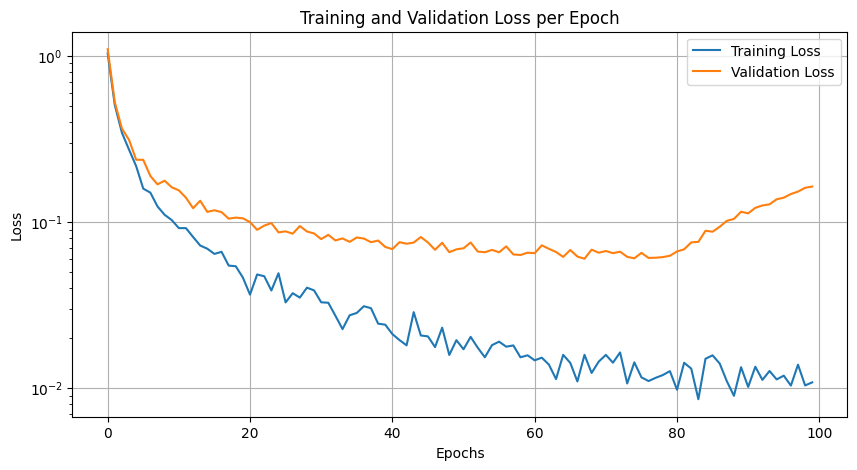

In [ ]:
x_values = range(len(rnn.losses[0]))

plt.plot(x_values, rnn.losses[0], label='Training Loss')
plt.plot(x_values, rnn.losses[1], label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

### LSTM

In [ ]:
class LSTM(SimpleRNN):
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size)
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

        self.dWf = np.zeros_like(self.Wf)
        self.dWi = np.zeros_like(self.Wi)
        self.dWc = np.zeros_like(self.Wc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbf = np.zeros_like(self.bf)
        self.dbi = np.zeros_like(self.bi)
        self.dbc = np.zeros_like(self.bc)
        self.dbo = np.zeros_like(self.bo)

        self.states = []
        self.gates = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.square(x)

    def forward_step(self, x, h_prev, c_prev):
        z = np.row_stack((h_prev, x))
        f = self.sigmoid(np.dot(self.Wf, z) + self.bf)
        i = self.sigmoid(np.dot(self.Wi, z) + self.bi)
        c_bar = self.tanh(np.dot(self.Wc, z) + self.bc)
        c = f * c_prev + i * c_bar
        o = self.sigmoid(np.dot(self.Wo, z) + self.bo)
        h = o * self.tanh(c)

        self.states.append((h_prev, c_prev, z, h, c, i, f, o, c_bar))
        return h, c

    def backward_step(self, dh_next, dc_next):
        h_prev, c_prev, z, h, c, i, f, o, c_bar = self.states.pop()

        do = dh_next * self.tanh(c) * self.sigmoid_derivative(o)
        self.dWo += np.dot(do, z.T)
        self.dbo += do

        dc = (dh_next * o * self.tanh_derivative(self.tanh(c))) + dc_next
        dc_bar = dc * i * self.tanh_derivative(c_bar)
        self.dWc += np.dot(dc_bar, z.T)
        self.dbc += dc_bar

        di = dc * c_bar * self.sigmoid_derivative(i)
        self.dWi += np.dot(di, z.T)
        self.dbi += di

        df = dc * c_prev * self.sigmoid_derivative(f)
        self.dWf += np.dot(df, z.T)
        self.dbf += df

        dz = np.dot(self.Wf.T, df) + np.dot(self.Wi.T, di) + np.dot(self.Wc.T, dc_bar) + np.dot(self.Wo.T, do)
        dh_prev = dz[:self.hidden_size]
        dc_prev = f * dc

        return dh_prev, dc_prev

    def clear_gradients(self):
        self.dWf.fill(0)
        self.dWi.fill(0)
        self.dWc.fill(0)
        self.dWo.fill(0)
        self.dbf.fill(0)
        self.dbi.fill(0)
        self.dbc.fill(0)
        self.dbo.fill(0)

In [ ]:
input_size = 10
hidden_size = 20
output_size = 1

lstm = LSTM(input_size, hidden_size, output_size)

lstm.train(data['Usage_kWh_norm'], learning_rate=0.01, epochs=100)

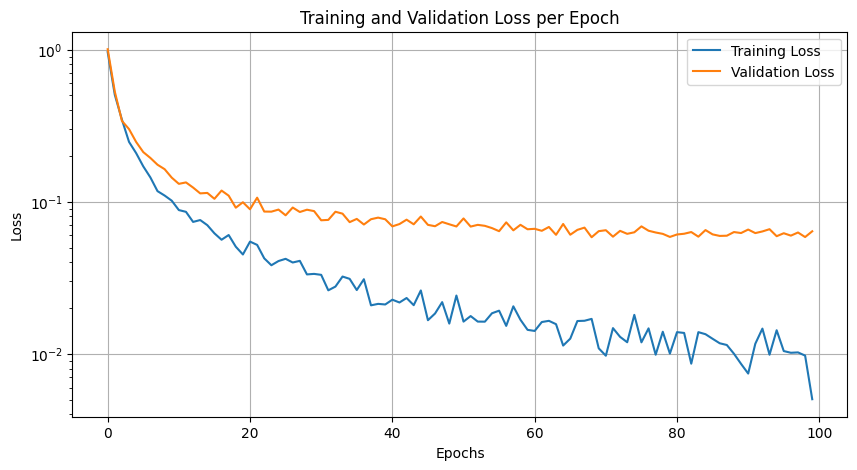

In [ ]:
x_values = range(len(lstm.losses[0]))

plt.plot(x_values, lstm.losses[0], label='Training Loss')
plt.plot(x_values, lstm.losses[1], label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

### GRU

In [ ]:
class GRU(SimpleRNN):
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wz = np.random.randn(hidden_size, input_size + hidden_size)
        self.Wr = np.random.randn(hidden_size, input_size + hidden_size)
        self.Wh = np.random.randn(hidden_size, input_size + hidden_size)
        self.bz = np.zeros((hidden_size, 1))
        self.br = np.zeros((hidden_size, 1))
        self.bh = np.zeros((hidden_size, 1))

        self.dWz = np.zeros_like(self.Wz)
        self.dWr = np.zeros_like(self.Wr)
        self.dWh = np.zeros_like(self.Wh)
        self.dbz = np.zeros_like(self.bz)
        self.dbr = np.zeros_like(self.br)
        self.dbh = np.zeros_like(self.bh)

        self.reset()

    def reset(self):
        self.h = np.zeros((self.hidden_size, 1))
        self.cache = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward_step(self, x):
        z = self.sigmoid(np.dot(self.Wz, np.vstack((self.h, x))) + self.bz)
        r = self.sigmoid(np.dot(self.Wr, np.vstack((self.h, x))) + self.br)
        h_hat = self.tanh(np.dot(self.Wh, np.vstack((r * self.h, x))) + self.bh)
        new_h = (1 - z) * h_hat + z * self.h

        self.cache.append((z, r, h_hat, self.h, x))
        self.h = new_h

        return new_h

    def sigmoid_derivative(self, s):
        return s * (1 - s)

    def tanh_derivative(self, t):
        return 1 - t**2

    def backward_step(self, dnext_h):
        z, r, h_hat, prev_h, x = self.cache.pop()
        combined = np.vstack((prev_h, x))

        dh_hat = dnext_h * (1 - z)
        dz = dnext_h * (prev_h - h_hat)
        dr = np.dot(self.Wh[:, :self.hidden_size].T, dh_hat * self.tanh_derivative(h_hat)) * prev_h

        dz *= self.sigmoid_derivative(z)
        dr *= self.sigmoid_derivative(r)

        self.dWz += np.dot(dz, combined.T)
        self.dbz += dz

        self.dWr += np.dot(dr, combined.T)
        self.dbr += dr

        dcombined_reset = np.dot(self.Wh.T, dh_hat * self.tanh_derivative(h_hat))
        dprev_h = dcombined_reset[:self.hidden_size] * r
        dprev_h += dnext_h * z
        dx = dcombined_reset[self.hidden_size:]

        self.dWh += np.dot(dh_hat * self.tanh_derivative(h_hat), np.vstack((r * prev_h, x)).T)
        self.dbh += dh_hat * self.tanh_derivative(h_hat)

        return dprev_h, dx

    def clear_gradients(self):
        self.dWz.fill(0)
        self.dWr.fill(0)
        self.dWh.fill(0)
        self.dbz.fill(0)
        self.dbr.fill(0)
        self.dbh.fill(0)

In [ ]:
input_size = 10
hidden_size = 20
output_size = 1

gru = GRU(input_size, hidden_size, output_size)

gru.train(data['Usage_kWh_norm'], learning_rate=0.01, epochs=100)

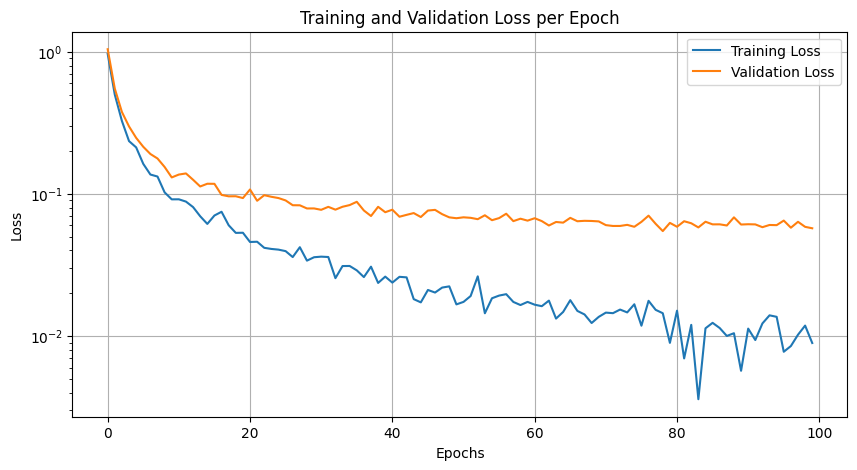

In [ ]:
x_values = range(len(gru.losses[0]))

plt.plot(x_values, gru.losses[0], label='Training Loss')
plt.plot(x_values, gru.losses[1], label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

## Вопросы

Зачем нужна seq_len, если RNN может обрабатывать последовательности бесконечно?

**Ответ:**

Seq_len, или длина последовательности, является важным параметром при работе с рекуррентными нейронными сетями (RNN). Давайте рассмотрим, зачем она нужна и какие функции выполняет в контексте обучения RNN.

1. Ограничение длины контекста: Хотя теоретически RNN могут обрабатывать данные произвольной длины за счёт своей способности передавать скрытое состояние из шага в шаг, на практике длина, которую модель может эффективно учиться использовать, ограничена. Это связано с двумя основными проблемами: затуханием и взрывным ростом градиентов при обучении через большое количество временных шагов. Seq_len позволяет ограничить количество шагов, по которым распространяется градиент во время обучения, помогая таким образом управлять этими проблемами.

2. Эффективность вычислений: Обработка очень длинных последовательностей может быть вычислительно затратной из-за необходимости обрабатывать большое число временных шагов. Установка определённой длины последовательности (seq_len) помогает планировать и оптимизировать вычислительные ресурсы.

3. Пакетная обработка (batch processing): Во многих случаях данные обучения подаются в RNN в виде пакетов (batches) для более эффективного обучения. Чтобы обработать несколько последовательностей параллельно в виде пакета, все последовательности в пакете должны иметь одинаковую длину (или быть дополнены до определённой длины). Seq_len используется для унификации длины последовательностей в пакете.

4. Динамическое изменение длины: В некоторых случаях, особенно когда данные имеют переменную длину (например, тексты разной длины), seq_len может динамически адаптироваться к каждому образцу в пакете. Это позволяет модели эффективнее обрабатывать такие данные, не тратя ресурсы на обработку "пустого" пространства после окончания реальных данных.

Таким образом, хотя RNN теоретически могут обрабатывать данные бесконечной длины, на практике использование параметра seq_len помогает сделать процесс обучения более управляемым, эффективным и адаптивным к различным типам данных.